<a href="https://colab.research.google.com/github/shahkarKhan24/Anomaly-Detection-Using-Adverserial-Training/blob/main/DL_Sota_PyLightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Using Sota Approach [1]

So, after trying the simple method to detect an anomaly we also tried the method that was described in the sota paper[1]. Which is also a Generative Adversarial Network (GAN) based architecture consist of a generator and two separate discriminators. Generator model is just like a simple U-net or an autoencoder and discriminator is a decoder like network.

In [1]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-rqazs5ir
  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-rqazs5ir
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit 1307b605e858560a1b93bfbbbbe039e5beb9e977
  Running command git submodule update --init --recursive -q
  Encountered 31 file(s) that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
import torchvision.transforms as transforms
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import pytorch_lightning as pl 
import torchmetrics 
from torchmetrics import Metric

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [4]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir 
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage):
        entire_dataset = datasets.FashionMNIST(
            root=self.data_dir, 
            train=True,
            transform=transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5,), (0.5,)),]),
            download=False,
        )

        
        self.test_ds = datasets.FashionMNIST(
            root=self.data_dir,
            train=False,
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]),
            download=False,
        )

    def train_dataloader(self):

        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [5]:
# This function is used to visualize results/images whenever required

def show_image(img, title):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert from tensor
    figure(figsize=(15, 6), dpi=80)
    plt.title(title, loc = 'center')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Convert (3,32,32) to (32,32,3)
    plt.show()

In Below two block of code we have design Ganerator and descrimanator network, we also tried to keep both as balance as we can, so niether can be strong from one another

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.disc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded # We are using two arguments here, because we also want encoded lattent space loss

In [8]:
y_test=[]
y_pred=[]

class GAN_Sota(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False
        self.loss_fn = nn.MSELoss()
        # Here we initialize two Discrimanators and one generator as per sota
        self.generator = Generator()
        self.disc_Normal = Discriminator()
        self.disc_Anomaly = Discriminator()

    def forward(self, img):
        x=self.generator(img)
        return x


    def training_step(self, batch, batch_idx):

        opt_g, opt_dN, opt_dA = self.optimizers()
        nor_img=[]
        An_img=[]

        img, lab = batch
        # we are spliting a batch here into normal and anomally data before feeding it into our model saparately
        for i in range(lab.shape[0]):
            if lab[i]==(0):
              nor_img.append(img[i])
            if lab[i] != (0):
              An_img.append(img[i])

        if nor_img !=[]:
            Normal_data = torch.stack(nor_img)
            z, fakeN = self.forward(Normal_data)
            z_prime, _ = self.forward(fakeN)# for calculating encoded loss after reconstruction

            self.toggle_optimizer(opt_dN)
            disc_real = self.disc_Normal(Normal_data).view(-1) # output of sigmoid function after feeding REAL image
            lossD_real = self.loss_fn(disc_real, 
                                      torch.ones_like(disc_real)) # discrmiminater must detect this as real image so in place of actual output we put 1, ouput of dicrminater shoul also be one 
            disc_fake = self.disc_Normal(fakeN).view(-1)# output of sigmoid function after feeding FAKE image
            lossD_fake = self.loss_fn(disc_fake, 
                                      torch.zeros_like(disc_fake))# discrmiminater must detect this as Fake image so in place of actual output we put 0, ouput of dicrminater shoul also be zero
            lossD = (lossD_real + lossD_fake) / 2
            self.log("lossD", lossD, prog_bar=True)
            opt_dN.zero_grad()
            self.manual_backward(lossD,retain_graph=True)
            opt_dN.step()
            self.untoggle_optimizer(opt_dN)
            #
            self.toggle_optimizer(opt_g)
            output = self.disc_Normal(fakeN).view(-1)
            LGN3=self.loss_fn(z_prime, z)
            LGN1= self.loss_fn(fakeN, Normal_data)
            LGN2 = self.loss_fn(output, torch.ones_like(output))
            Total_loss_GN=torch.sigmoid((LGN1+LGN2+LGN3)/3)
            self.log("lossGN", Total_loss_GN, prog_bar=True)
            opt_g.zero_grad()
            self.manual_backward(Total_loss_GN)
            opt_g.step()
            self.untoggle_optimizer(opt_g)

        if An_img !=[]:
            Anomaly_data =torch.stack(An_img)
            _ , fakeA = self.forward(Anomaly_data)

            self.toggle_optimizer(opt_dA)
            Adisc_real = self.disc_Anomaly(Anomaly_data).view(-1) # output of sigmoid function after feeding REAL image
            lossAD_real = self.loss_fn(Adisc_real,
                                        torch.ones_like(Adisc_real)) # discrmiminater must detect this as real image so in place of actual output we put 1, ouput of dicrminater shoul also be one 
            Adisc_fake = self.disc_Anomaly(fakeA).view(-1)# output of sigmoid function after feeding FAKE image
            lossAD_fake = self.loss_fn(Adisc_fake,
                                        torch.zeros_like(Adisc_fake))# discrmiminater must detect this as Fake image so in place of actual output we put 0, ouput of dicrminater shoul also be zero
            # lossAD= -(torch.mean(Adisc_real)-torch.mean(Adisc_fake))
            lossAD = (lossAD_real + lossAD_fake) / 2
            self.log("lossA", lossAD, prog_bar=True)
            opt_dA.zero_grad() 
            self.manual_backward(lossAD,retain_graph=True)
            opt_dA.step()
            self.untoggle_optimizer(opt_dA)

            self.toggle_optimizer(opt_g)
            output2 = self.disc_Anomaly(fakeA).view(-1)
            LGA1 = self.loss_fn(output2, torch.ones_like(output2))
            LGA2= self.loss_fn(fakeA, Anomaly_data)
            Total_loss_GA =-(torch.sigmoid((LGA1+LGA2))/2)
            self.log("lossGA", Total_loss_GA, prog_bar=True)
            opt_g.zero_grad()
            self.manual_backward(Total_loss_GA)
            opt_g.step()
            self.untoggle_optimizer(opt_g)


        if (batch_idx%1800==0) and (batch_idx !=0):
              # with torch.no_grad():
            if nor_img !=[]:
                show_image(torchvision.utils.make_grid(Normal_data.cpu()),"Normal Data" )
                show_image(torchvision.utils.make_grid(fakeN.cpu()), "Reconstructed Normal Data")
            if An_img !=[]:
                show_image(torchvision.utils.make_grid(Anomaly_data.cpu()),"Anomaly Data")
                show_image(torchvision.utils.make_grid(fakeA.cpu()), "Reconstructed Anomaly Data")


        nor_img=[]
        An_img=[]


    def configure_optimizers(self):

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=1e-3, weight_decay=1e-5)
        opt_d_N = torch.optim.Adam(self.disc_Normal.parameters(), lr=1e-3, weight_decay=1e-5)
        opt_d_A = torch.optim.Adam(self.disc_Anomaly.parameters(), lr=1e-3, weight_decay=1e-5)
        return [opt_g, opt_d_N, opt_d_A], []
    
    def test_step(self, batch, batch_idx):
        
        loss_N=0
        loss_A=0
        TP=0
        FN=0

        FP=0
        TN=0
        img, lab = batch
        
        if lab.item()==0:
            y_test.append(1)
            _, fakeN = self.forward(img)
            loss_N=torch.sigmoid(self.loss_fn(fakeN, img))
            if loss_N <= 0.6:
                TP+=1
                y_pred.append(1)
            elif loss_N > 0.6:
                FN+=1
                y_pred.append(0)
        
        if (lab.item()!=0):
            y_test.append(0)
            _, fakeA = self.forward(img)
            loss_A=torch.sigmoid(self.loss_fn(fakeA, img))
            if loss_A <= 0.6:
                FP+=1
                y_pred.append(1)
            elif loss_A > 0.6:
                TN+=1
                y_pred.append(0)
       
        self.log_dict({"Normal_loss": loss_N,"Anomaly_loss": loss_A})
        
        return {'lossN': loss_N, 'lossA': loss_A}

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)


train_dataset = datasets.FashionMNIST(root="dataset/",train=True, transform=transforms, download=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 116484647.57it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5054709.18it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 65448707.47it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25859014.36it/s]


Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



To design an anomaly detection algorithm, what we did is that we need to keep on class of the dataset as normal data and rest of the classes of the dataset as anomaly. For instance, we consider class 0 of Fashion-MNIST data set i.e., “Shirt” a normal class and rest of the classes of the dataset as anomaly data. This setup give rise to another problem during training that might be the distribution between normal data and anomaly data because the quantity of anomaly dataset is way more than normal to solve this problem after some research on internet we use data sampling technique which try to distribute the batches equally during training between normal class and anomaly class. 

In [11]:
#Data Sampling
class_weights=[1.0,  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
sample_weights= [0]*len(train_dataset)

for idx, (data, label) in enumerate(train_dataset):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights,
                                 num_samples=len(sample_weights), 
                                 replacement=True)

In [12]:

model = GAN_Sota()
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
trainer = pl.Trainer(max_epochs=15)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss_fn      | MSELoss       | 0     
1 | generator    | Generator     | 210 K 
2 | disc_Normal  | Discriminator | 105 K 
3 | disc_Anomaly | Discriminator | 105 K 
-----------------------------------------------
420 K     Trainable params
0         Non-trainable params
420 K     Total params
1.683     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

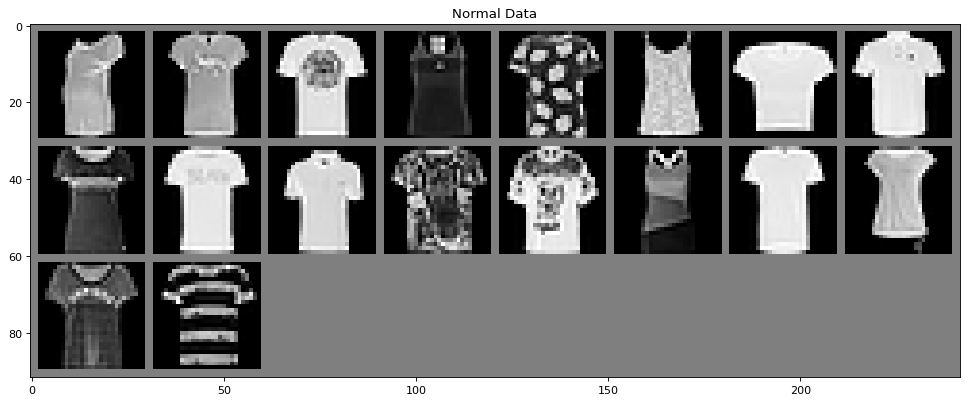

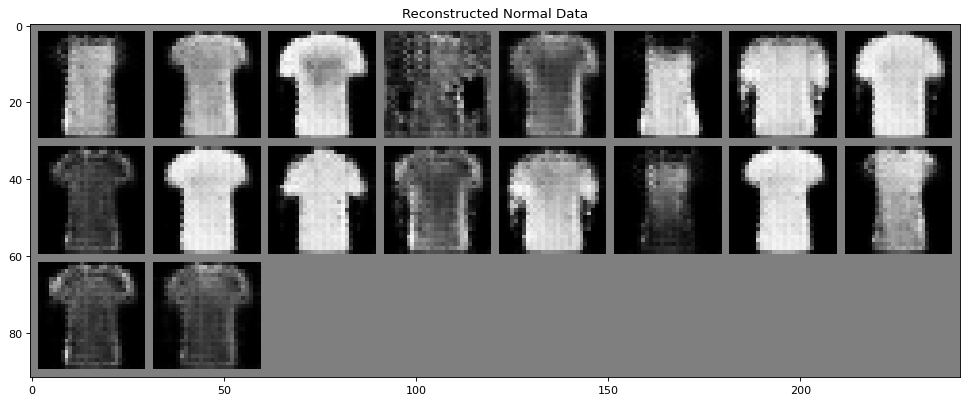

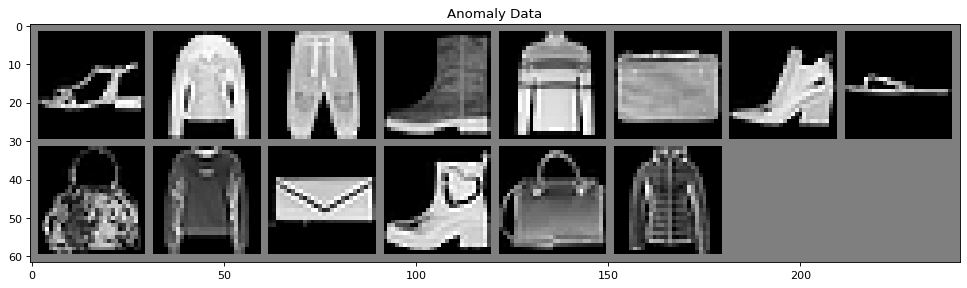

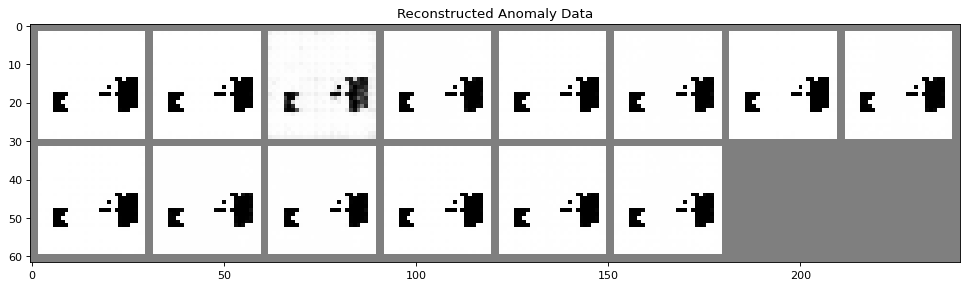

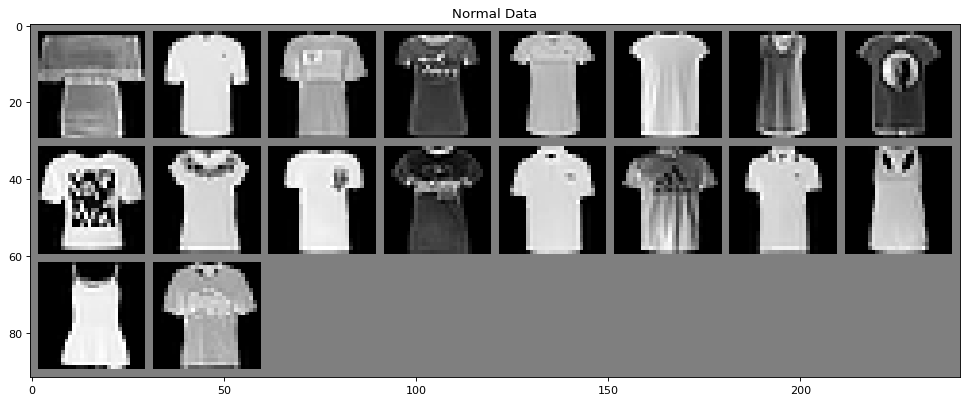

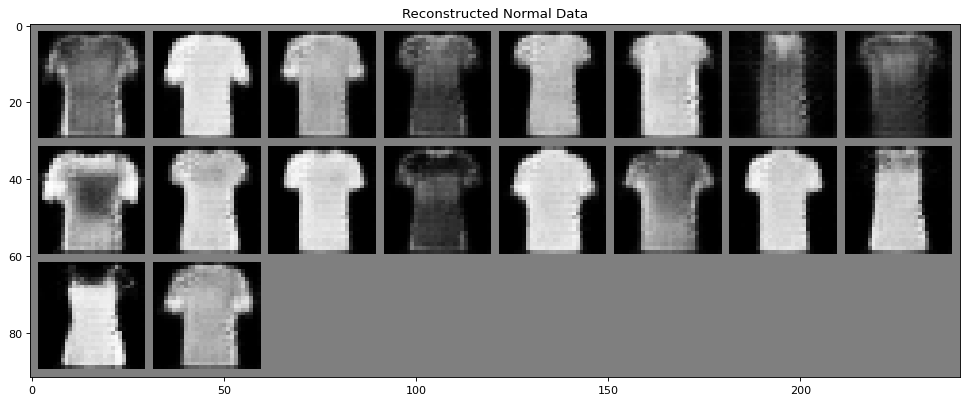

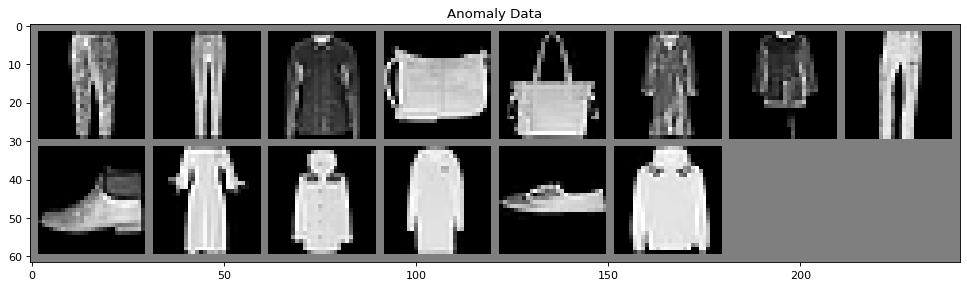

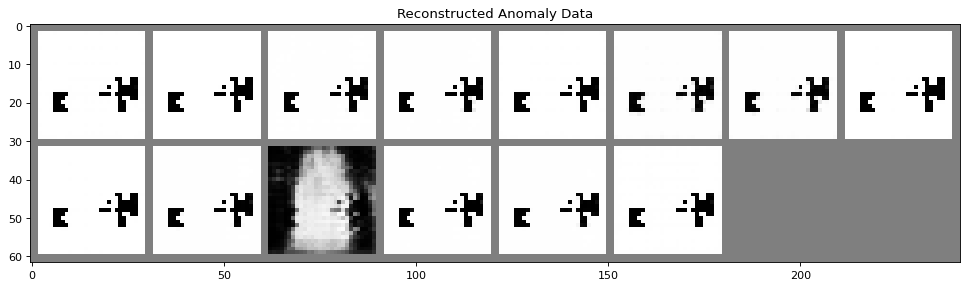

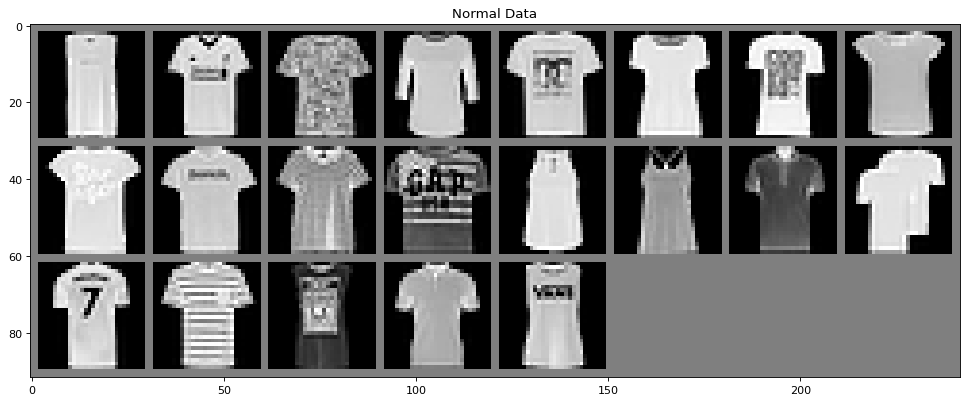

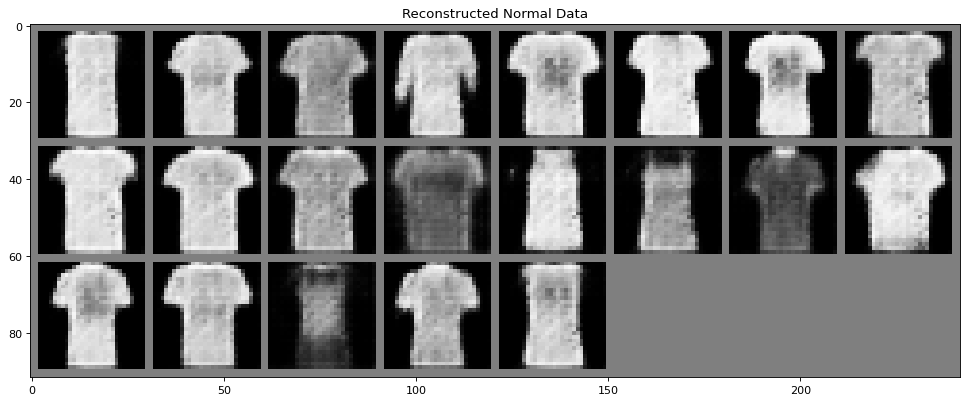

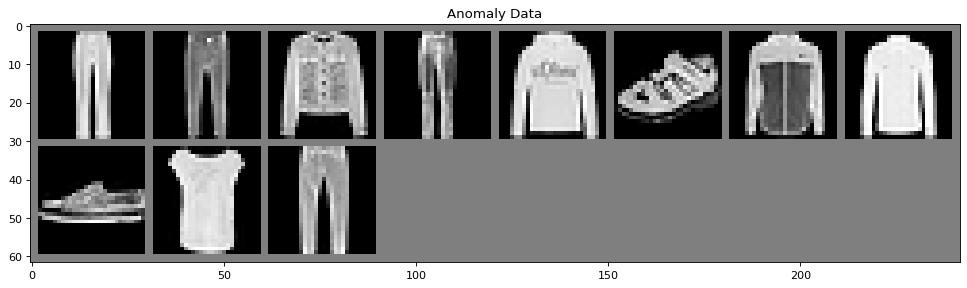

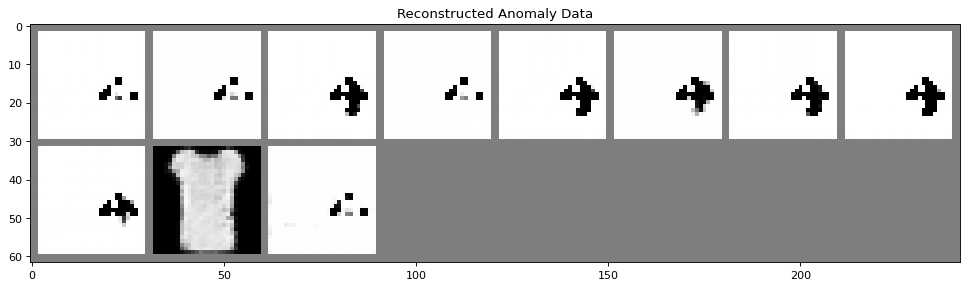

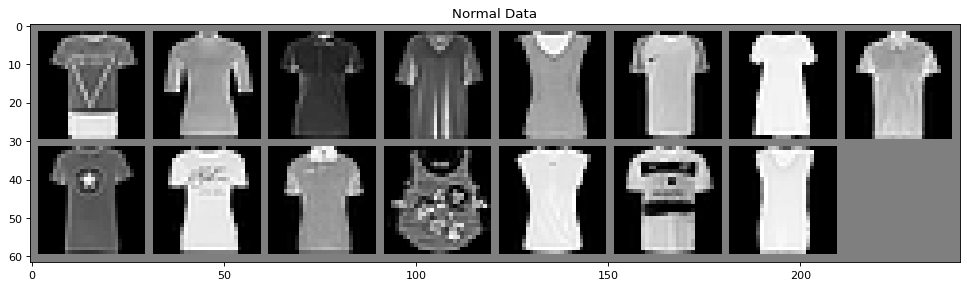

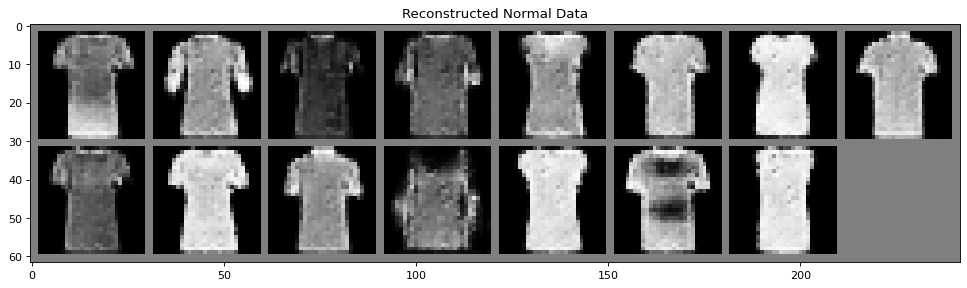

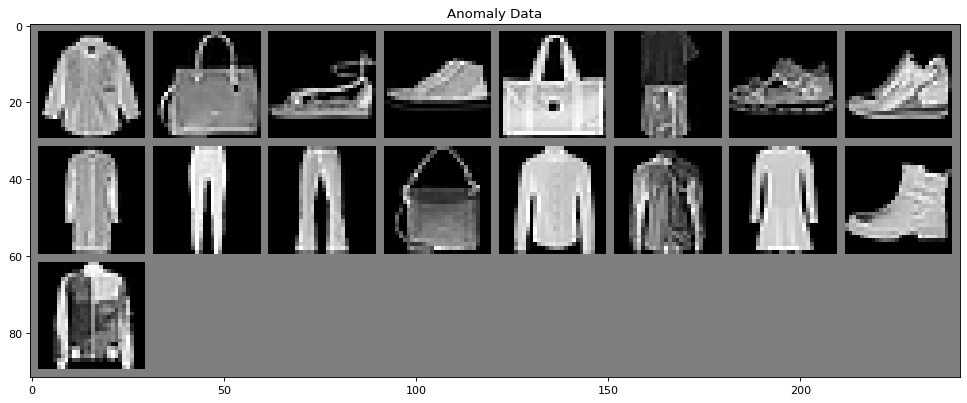

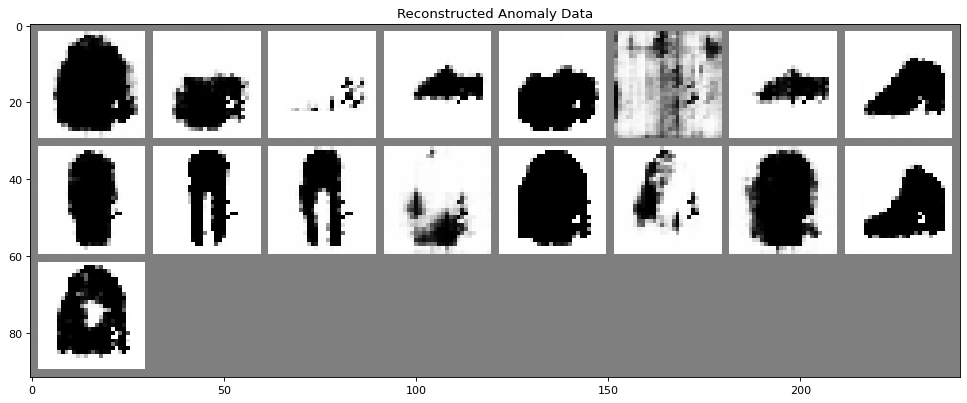

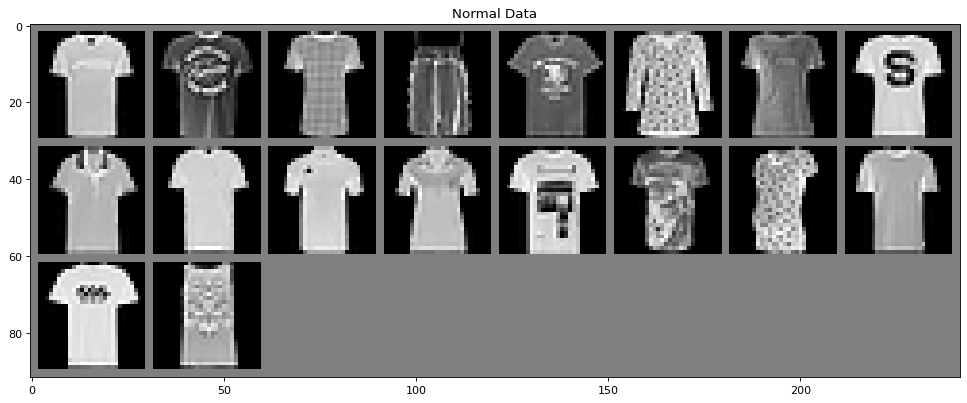

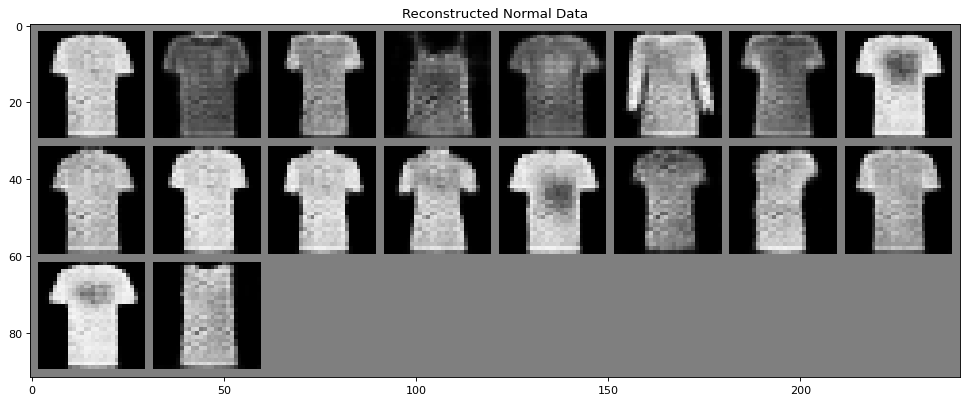

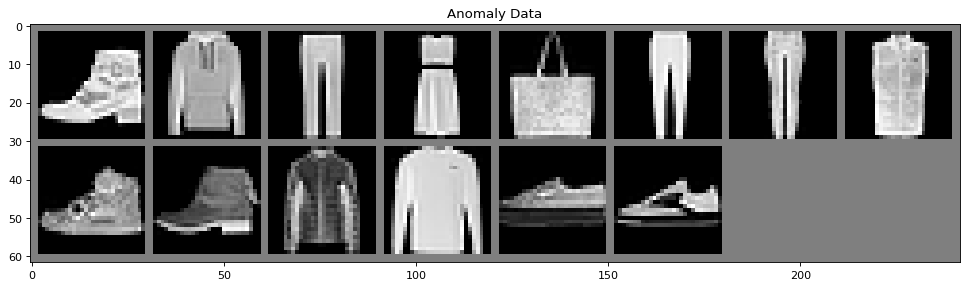

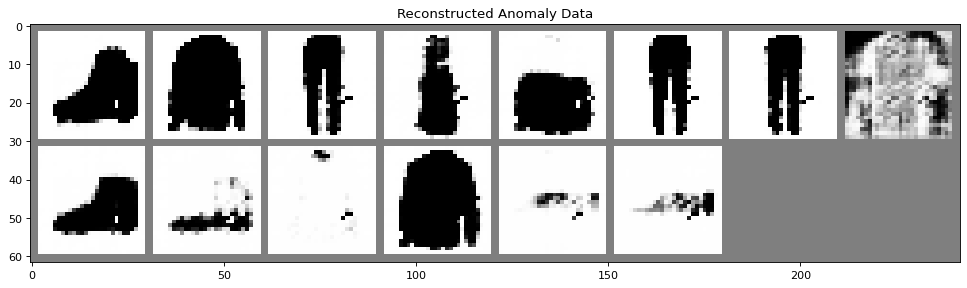

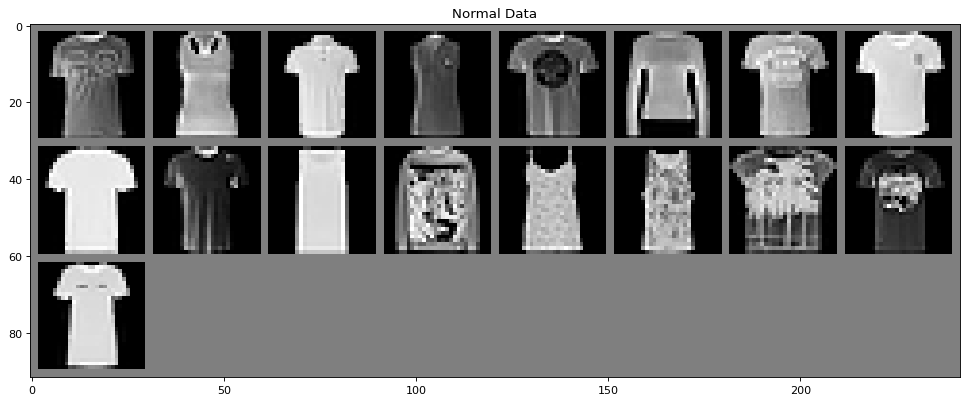

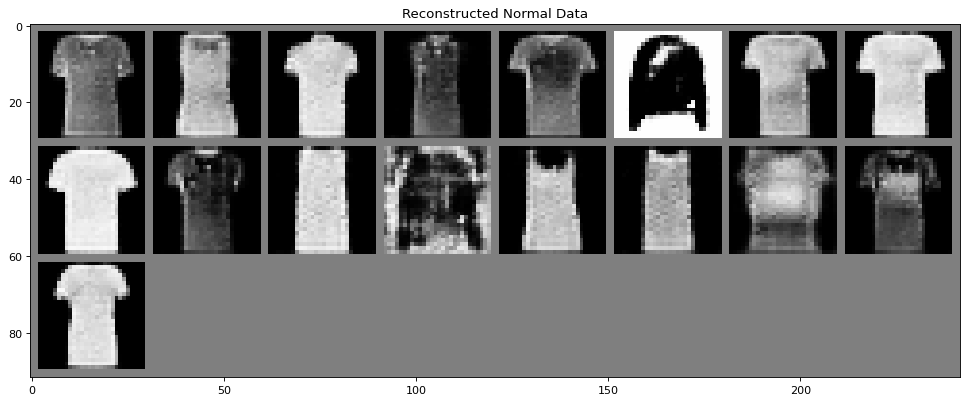

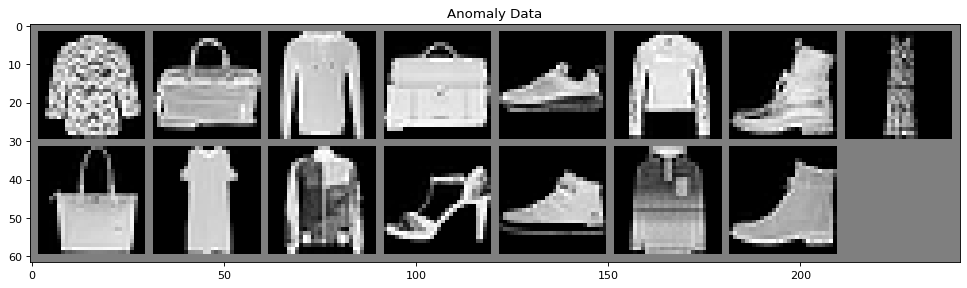

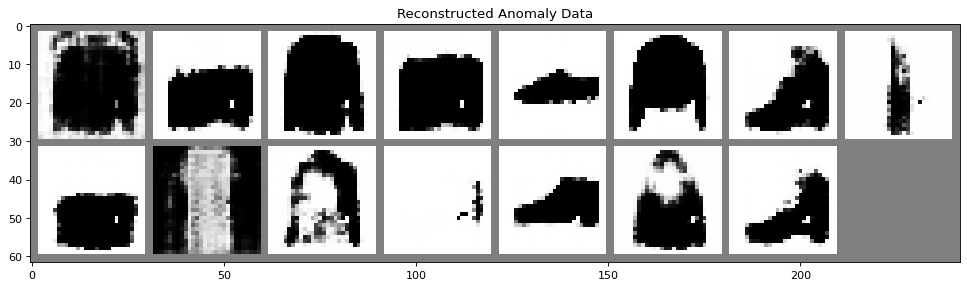

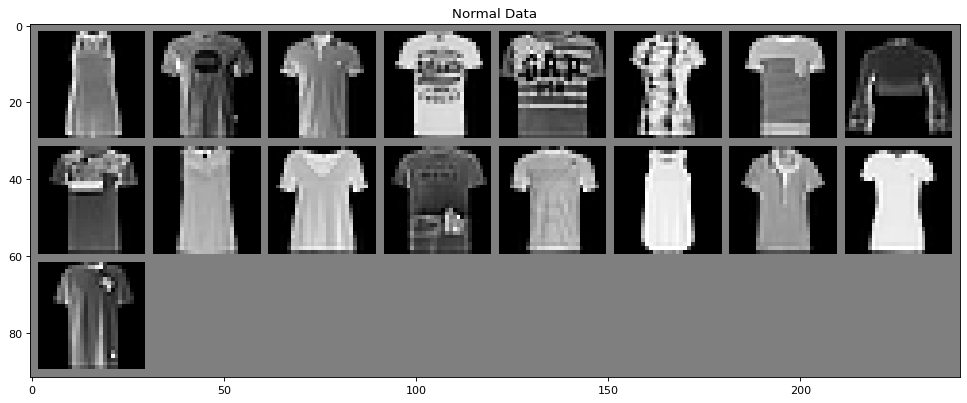

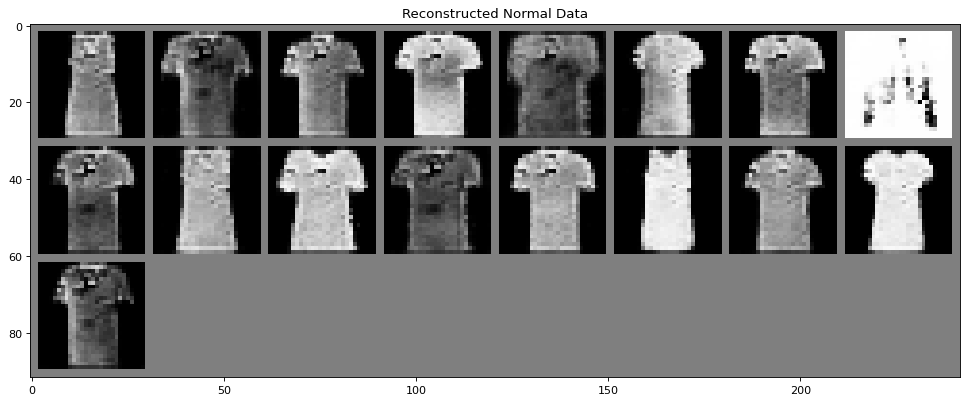

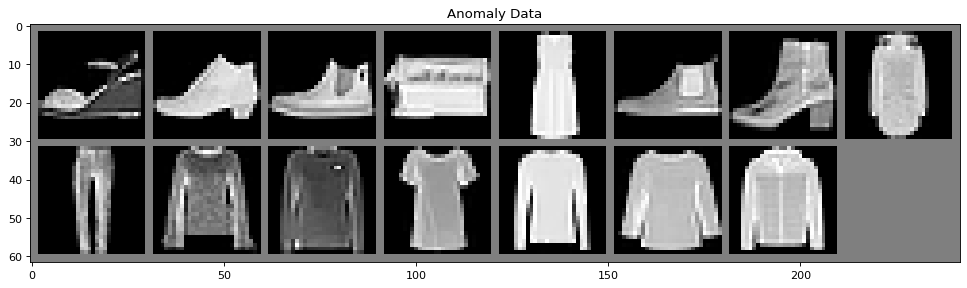

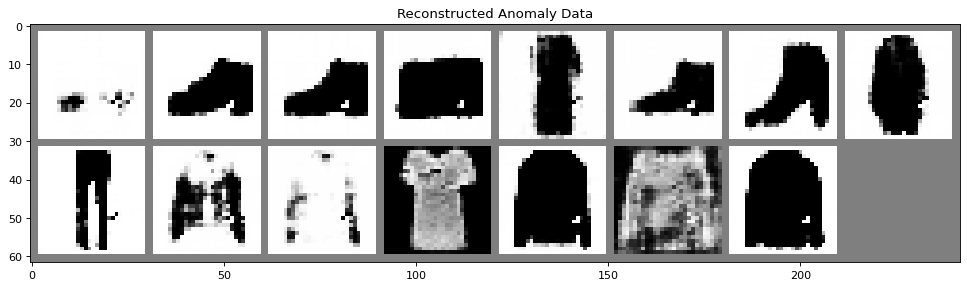

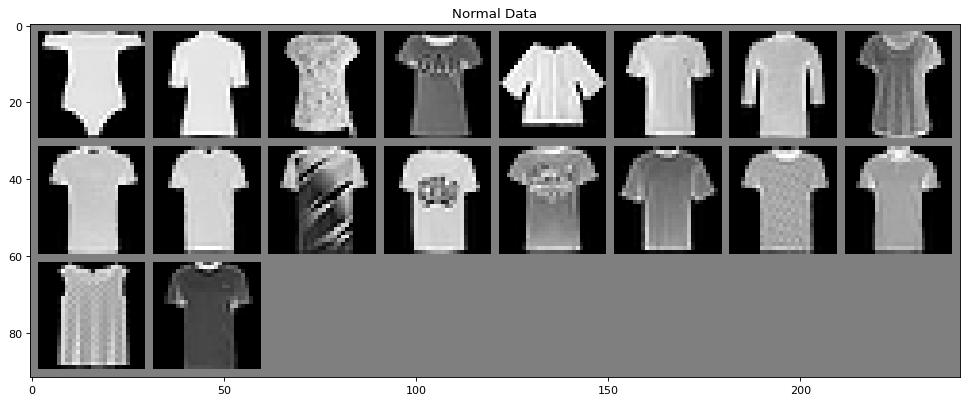

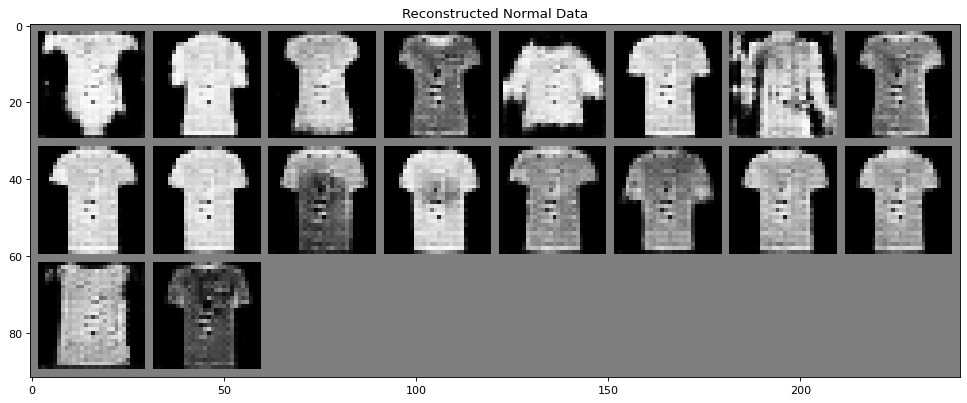

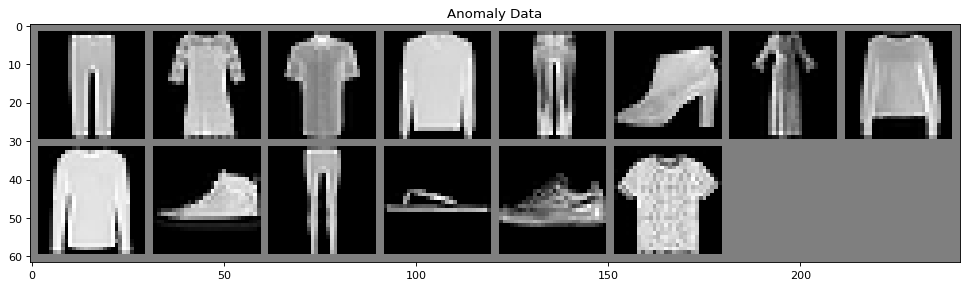

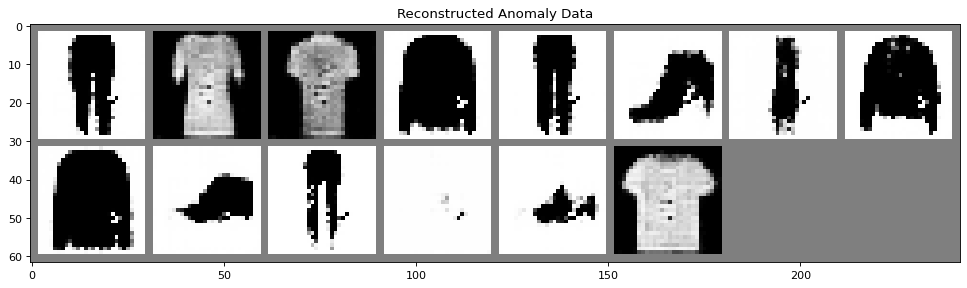

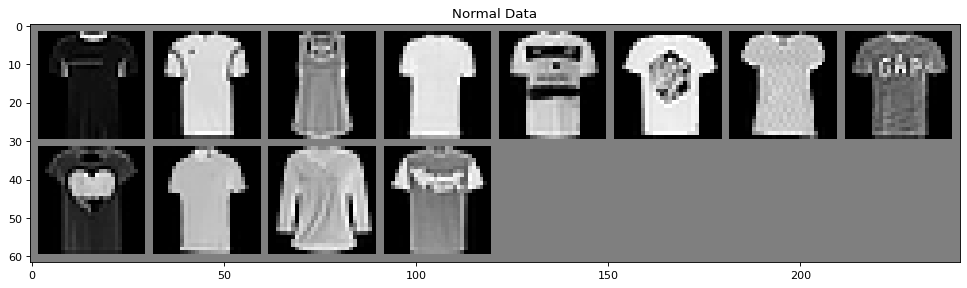

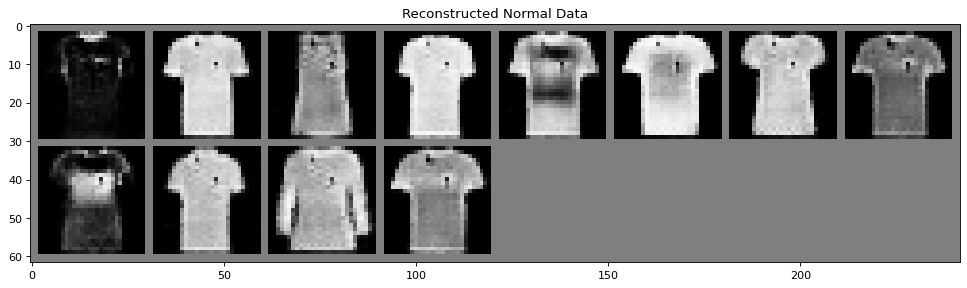

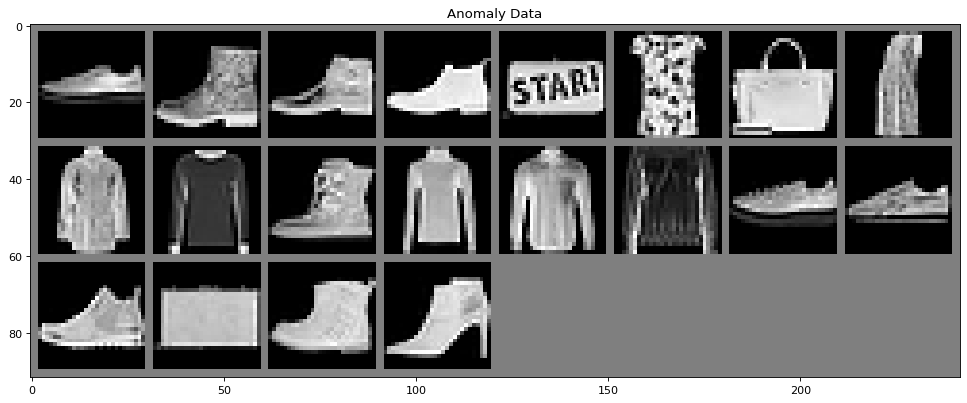

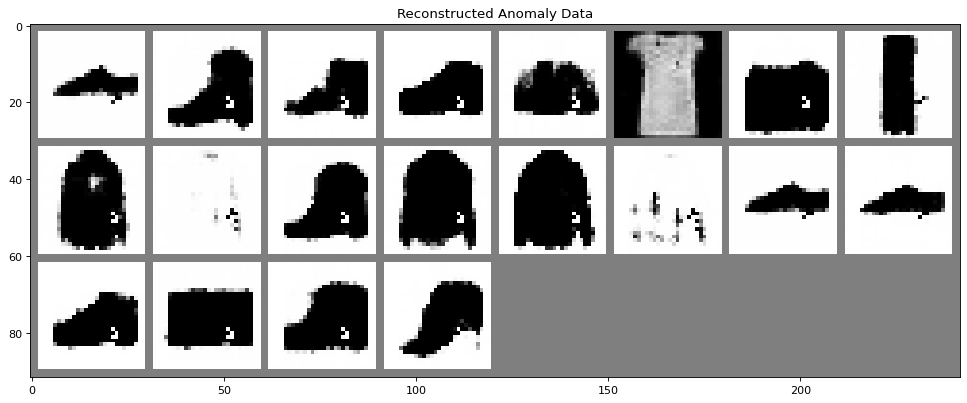

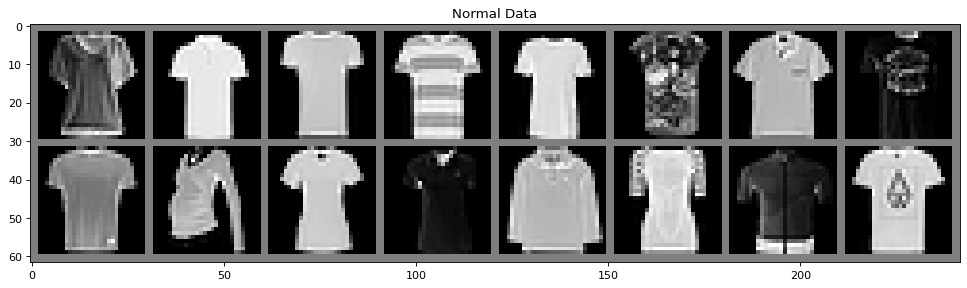

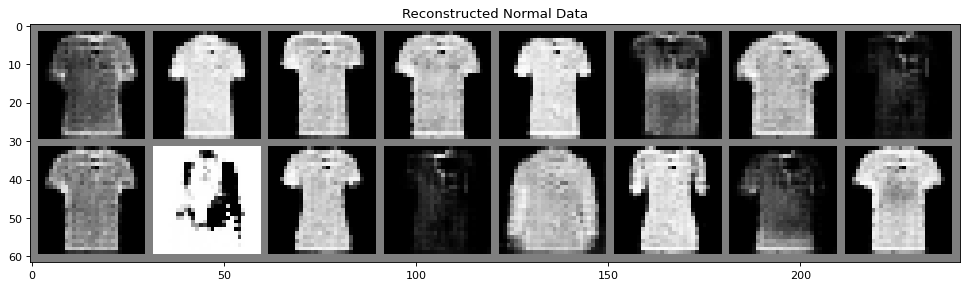

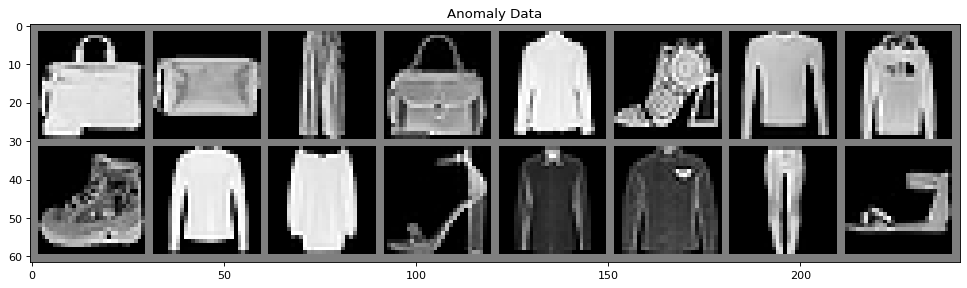

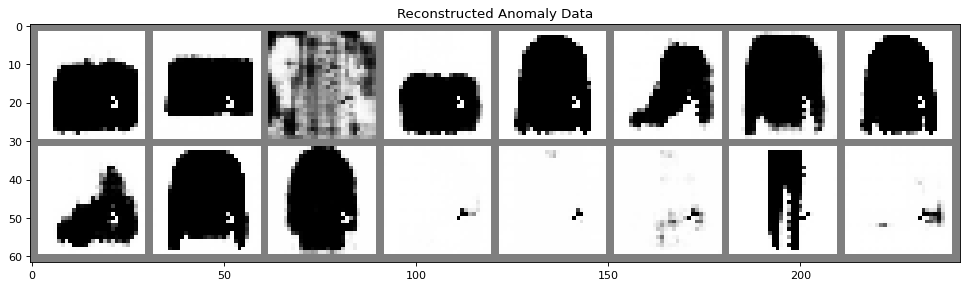

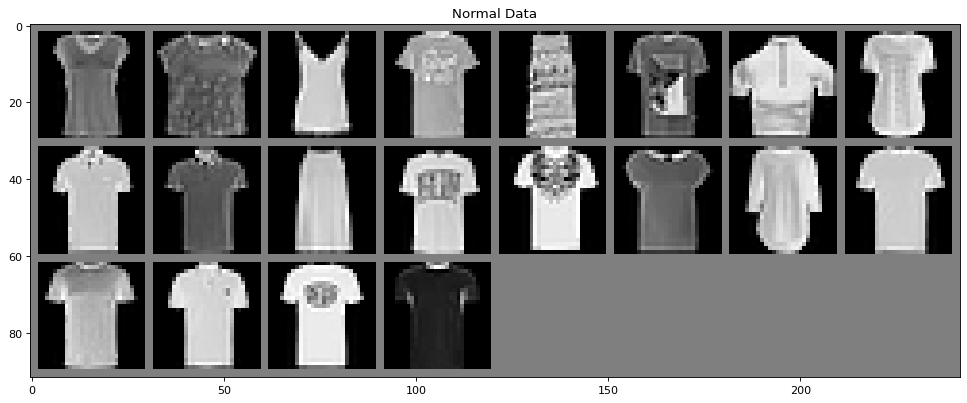

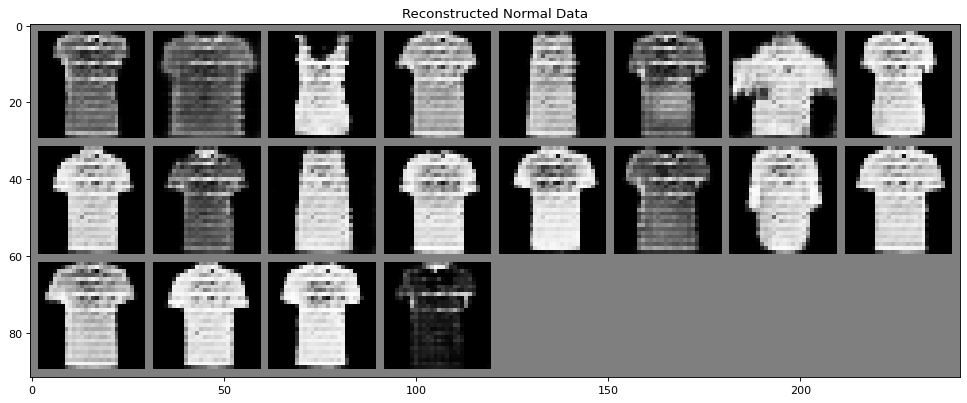

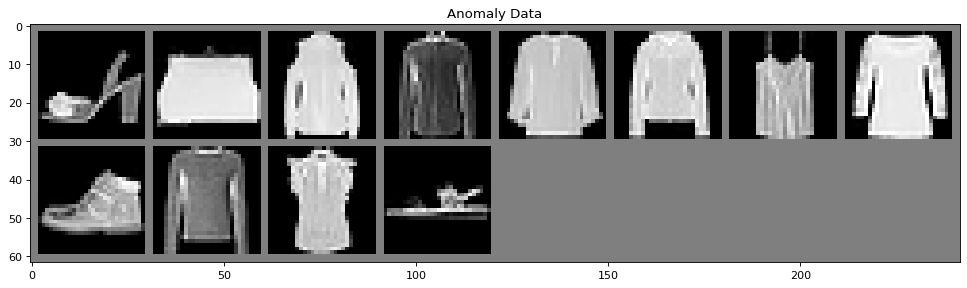

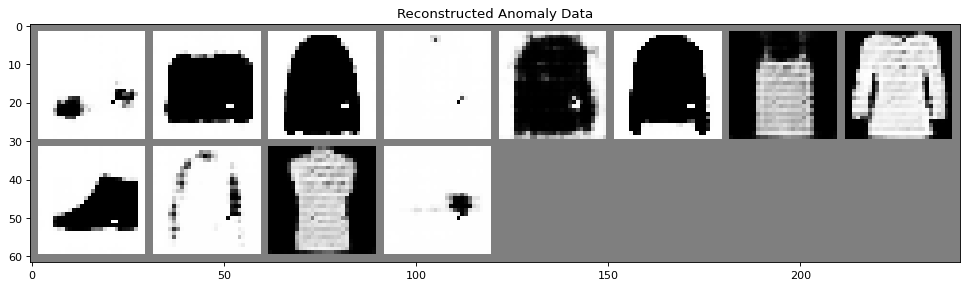

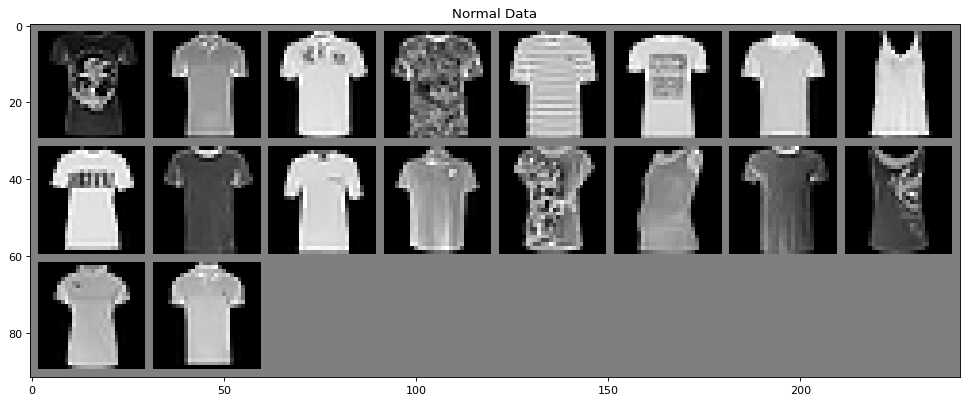

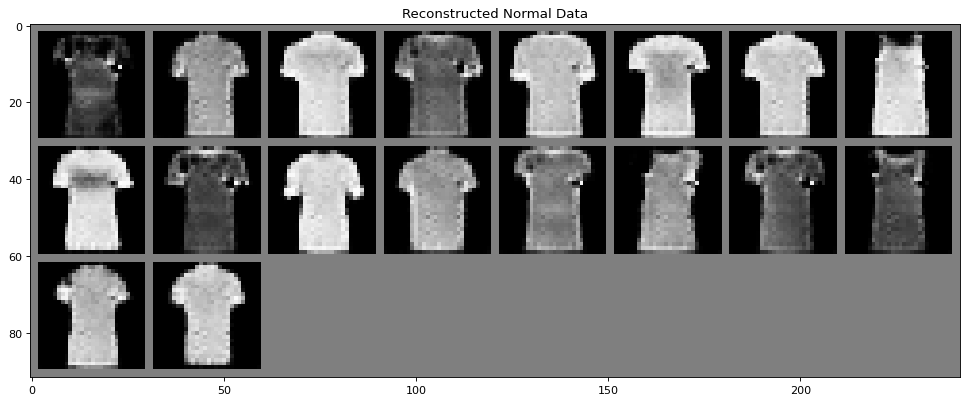

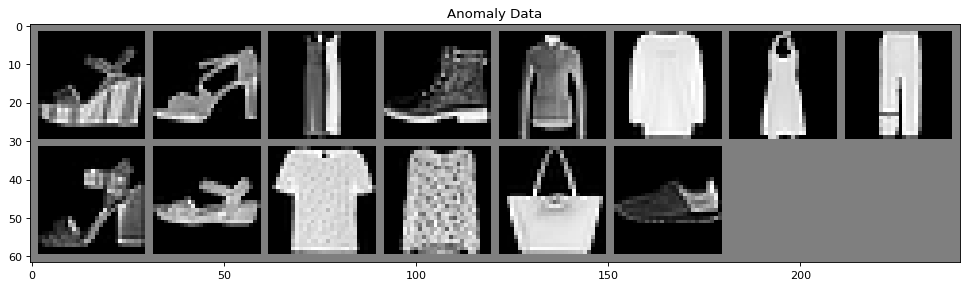

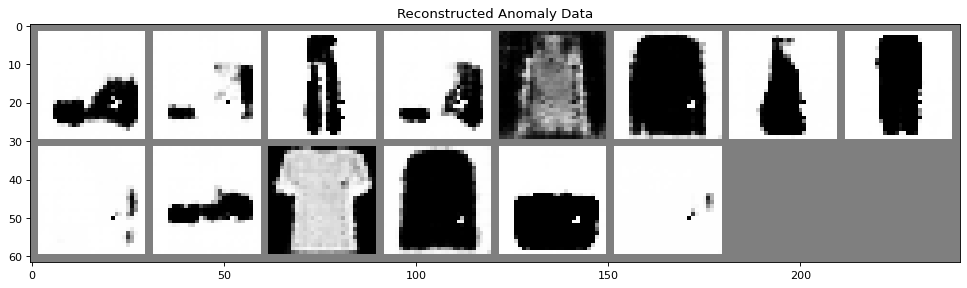

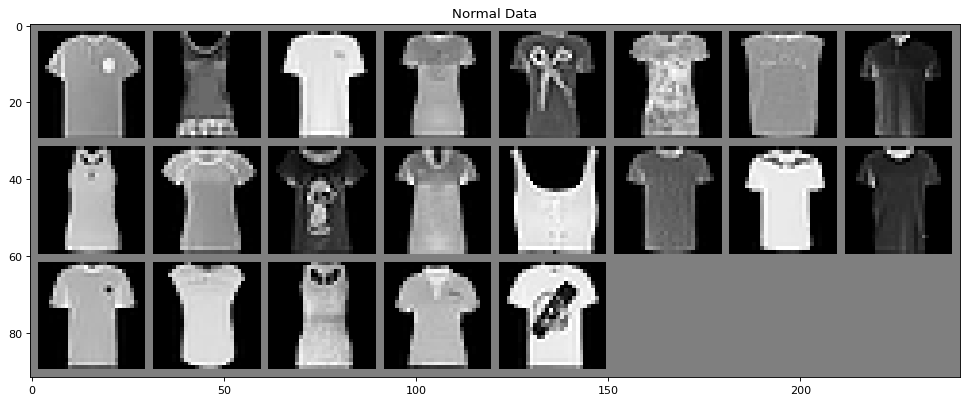

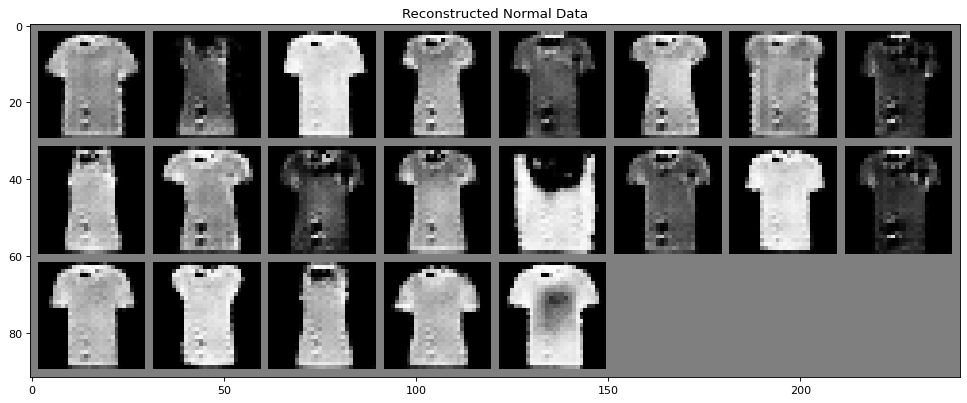

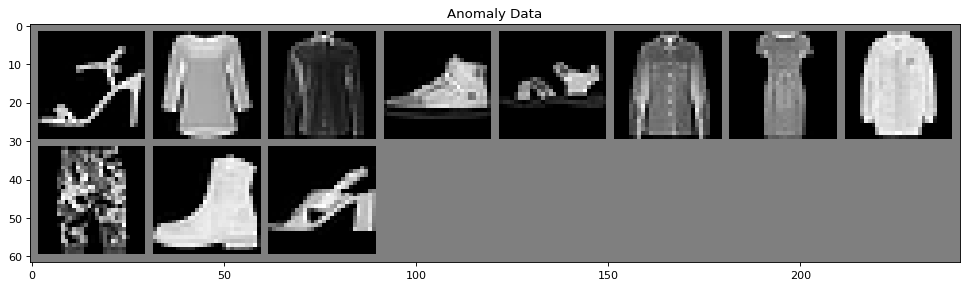

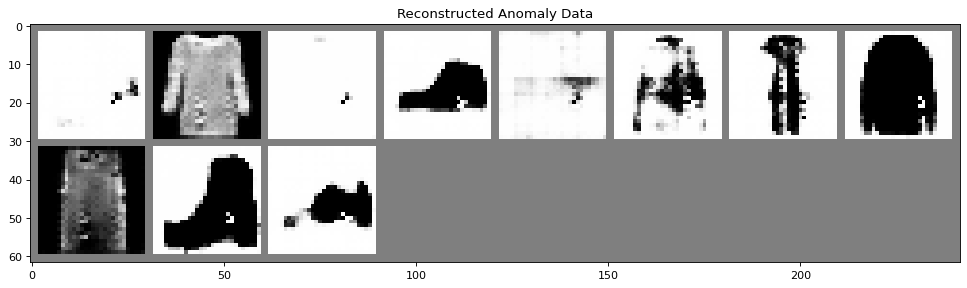

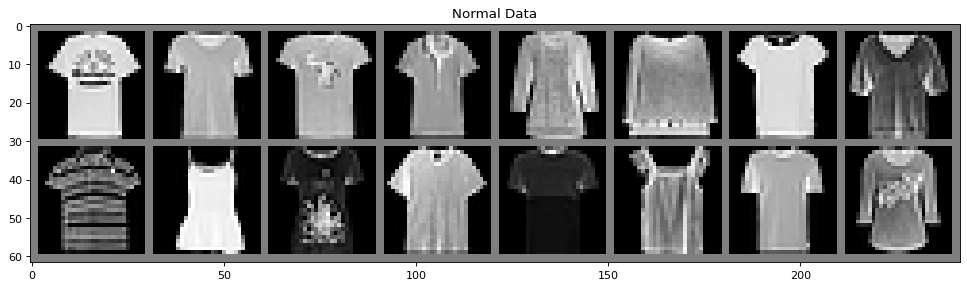

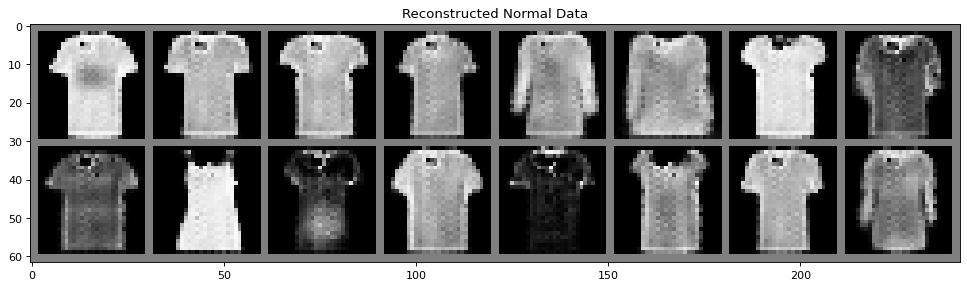

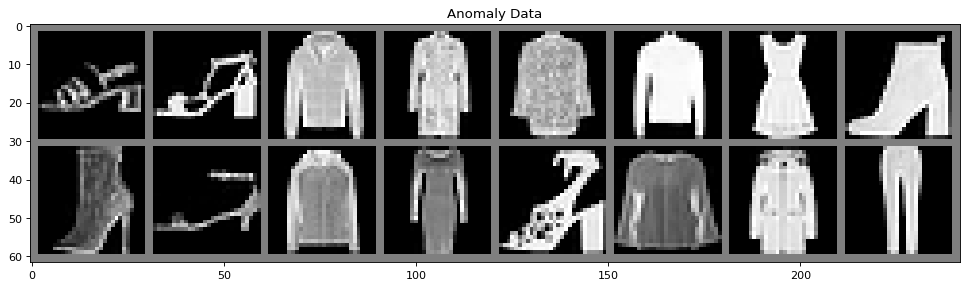

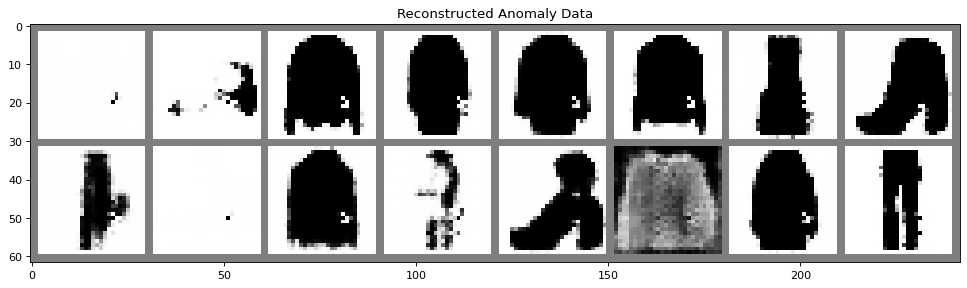

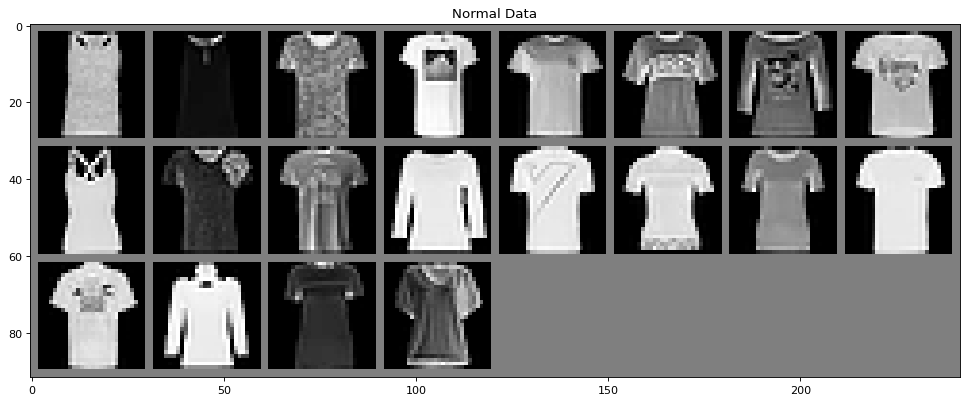

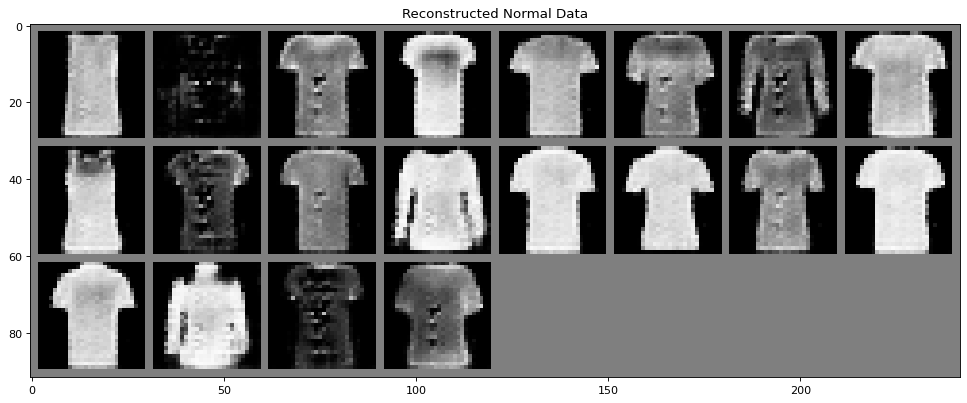

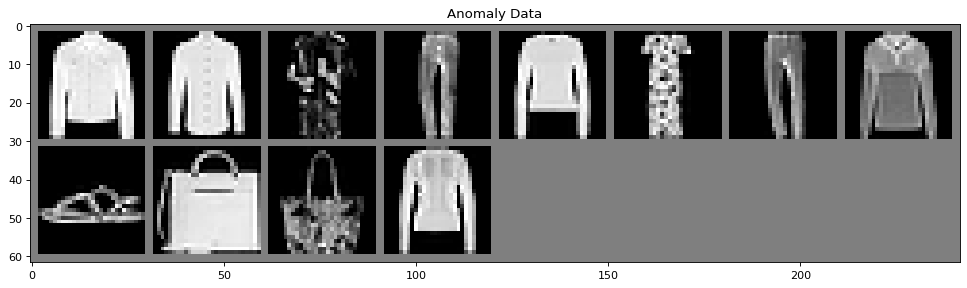

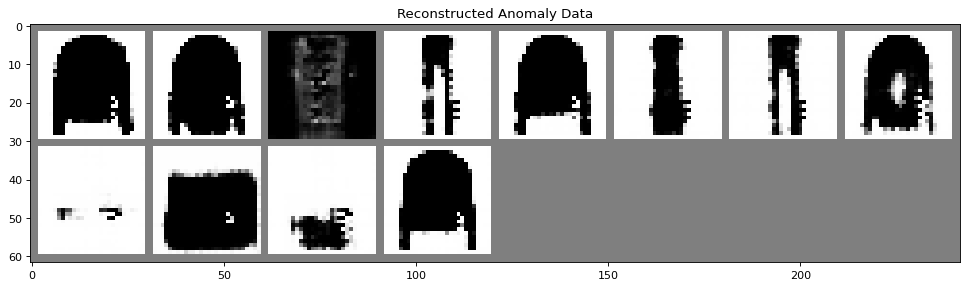

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [13]:


trainer.fit(model, train_loader)


In [14]:
test_dataset = datasets.FashionMNIST(root="dataset/",train= False, transform=transforms, download=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [15]:
L=trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('Normal_loss', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('Anomaly_loss', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Anomaly_loss        │     0.824769914150238     │
│        Normal_loss        │    0.05239415168762207    │
└───────────────────────────┴───────────────────────────┘

In [16]:
L

[{'Normal_loss': 0.05239415168762207, 'Anomaly_loss': 0.824769914150238}]

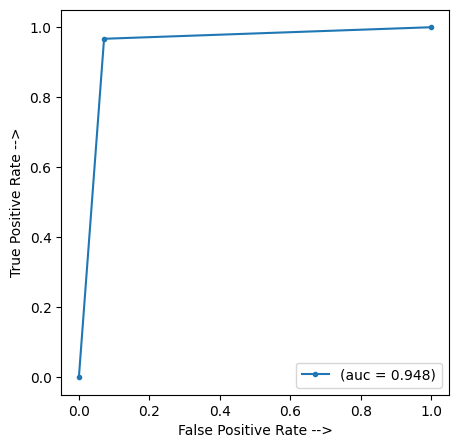

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)


plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='.', label='(auc = %0.3f)' % auc)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()

In [18]:
!pip install plot_metric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


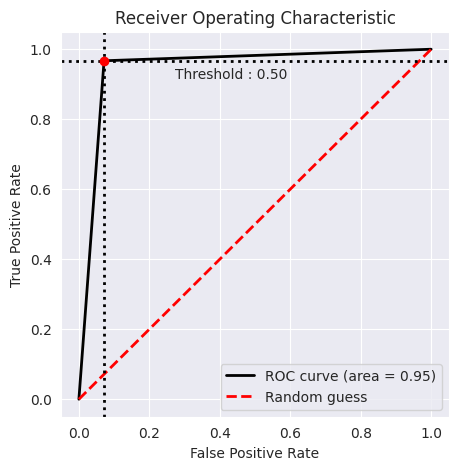

In [19]:
#from stack overflow
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()


<h3>References</h3>
Below are the references that were used in this project;

[1].  GAN-based Anomaly Detection in Imbalance Problems ( https://paperswithcode.com/paper/gan-based-anomaly-detection-in-imbalance )

[2].  Area Under the Receiver-Operating Characteristics ( https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html )
